<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 3 - Naive Forecasting methods
 
### Objectives

1. Learn how to implement the simple naive forecasting method (most recent value) in Python
2. Learn how to implement the seasonal naive forecasting method in Python
3. Learn how to correctly compare predictive performances of different forecasting methods.

In the Week 1 and Week 2 tutorials, we have learnt simple data manipulation in Time Series using Pandas. In this week, we will learn how to implement the simple naive and seasonal naive forecasting algorithms, which are collectively called as naive forecasting methods, in Python. We will also learn how to correctly evaluate and compare the out-of-sample performance, or predictive performance, of different naive forecasting methods on the Airpasssenger data.


## 1. Loading the AirPassenger dataset

Create a new Jupyter Notebook called "Tutorial_03.ipynb" and download the ***AirPassenger.csv*** file from Canvas. Let's begin our script by importing necessary libraries:

In [1]:
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra

Then read the data file into a `DataFrame` object and use the `Month` column as the index of the `DataFrame`

In [2]:
data = pd.read_csv('AirPassengers.csv')       # Read data from a csv file
data['Month'] = pd.to_datetime(data['Month']) # Convert the data in the Month column to datetime
data.set_index('Month', inplace=True)         # Indexing the DataFrame by the Month column
data.head()   # See the first 5 rows 
data.head(10)  # See the first 10 rows

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


Then we extract the `Passengers` column and plot the data:

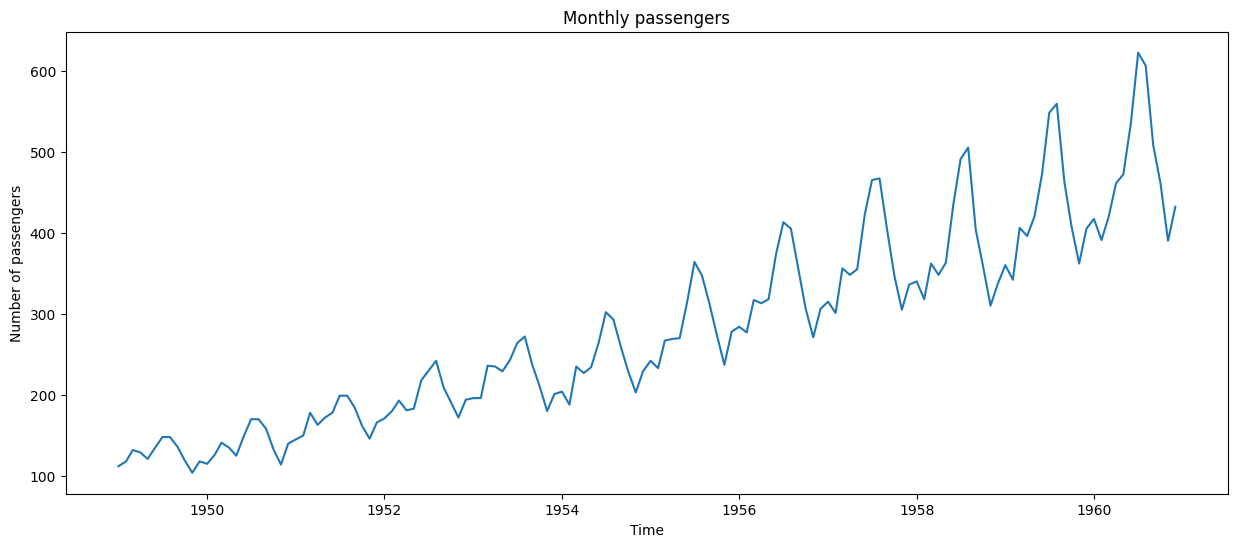

In [3]:
# Extract Passengers column
ts = data['Passengers']

# Plot number of passengers over time
plt.figure(figsize=(15,6))         
plt.plot(ts.index,ts)
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.title('Monthly passengers')
plt.show()

## 2. Prepare in-sample and out-of-sample data (train/test split)

Predictive modelling is the process of developing mathematical/statistical tools or models that generate useful forecast values for future (unseen) data. Normally, given a paricular dataset, several candidate models are proposed to fit the data and then the final model will be selected based on specific criteria, e.g. best in-sample fitting or best out-of-sample performance (predictive performance). In this unit, we are more interested in building models with good predictive performance. 

When evaluating the predictive performance of different candidate models, a common practice is to split the observed time series into two parts: in-sample data (or train data) is used to fit model parameters (or to train the model), and out-of-sample data (or test data) is used to measure the accuracy of forecast values produced from the candidate models. The process of spliting the observed data is called train/test split.

For the rest of the tutorial, let's denote a time series as $Y_{1:T}= \{Y_1, Y_2, ..., Y_T\}$, e.g. the time series has $T$ observations indexed by integers from $1$ to $T$. In this notation, $Y_t$ indicates observation at time $t$ with $t=1,...,T$. 

Denote $T_{in}$ and $T_{out}$ as the length of in-sample and out-of-sample periods, respectively. The time series $Y_{1:T}$ can be rewritten as 

$$Y_{1:T} = \{Y_1,...,Y_{T_{in}},Y_{T_{in}+1},...,Y_{T_{in}+T_{out}}\},$$

then the portion $\{Y_1,...,Y_{T_{in}}\}$ is the in-sample data and $\{Y_{T_{in}+1},...,Y_{T_{in}+T_{out}}\}$ is the out-of-sample data.

**Note:** The predictive performance of candidate models must be evaluated on the same out-of-sample data.

Now, let's implement the above train/test split step for the AirPassengers data. We use the observations during $1949-1959$ as the in-sample data and $1960$ as the out-of-sample data.

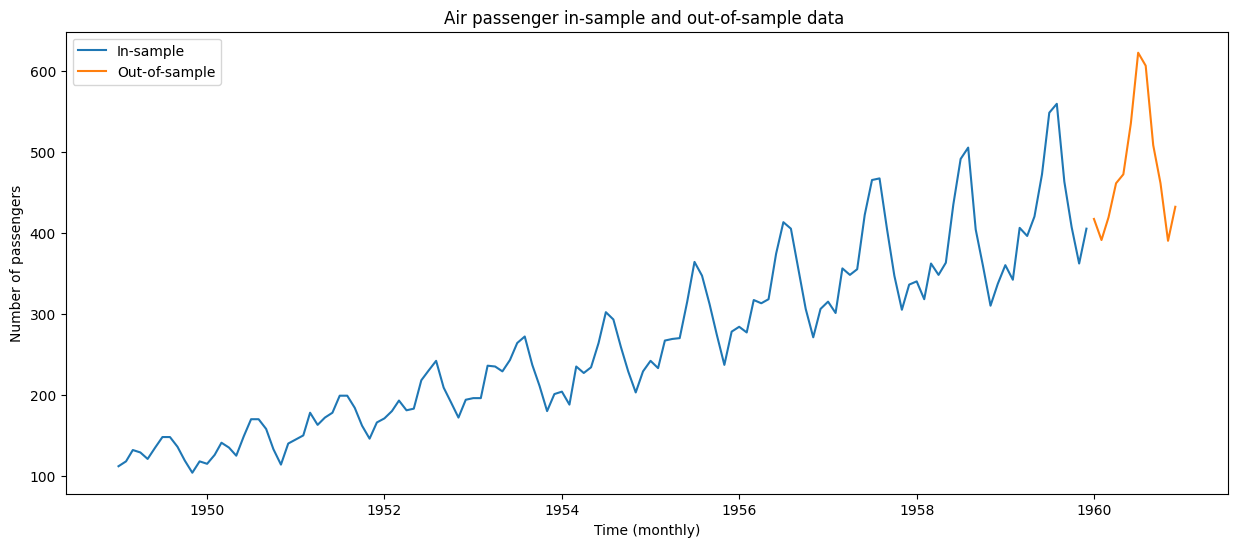

In [4]:
# Extract data for in-sample period (1949-1959)
ts_in = ts['1949':'1959']
T_in = len(ts_in) 
# 132 data
#因為亂跳會break the sequence
# Extract data for out-of-sample period (1960)
ts_out = ts['1960']
T_out = len(ts_out)
# 12 data

# Plot in-sample and out-of-sample data
# This step is important to make sure the train/test split is correct
plt.figure(figsize=(15,6))
plt.plot(ts_in)
plt.plot(ts_out)
plt.title('Air passenger in-sample and out-of-sample data ')
plt.xlabel('Time (monthly)')
plt.ylabel('Number of passengers')
plt.legend(['In-sample','Out-of-sample'])
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- How many observations in the in-sample and out-of-sample data?
<b>132 for out and 12 for in</b>
- How to choose out-of-sample size in general? **Hint:** see lecture 2
- If the time series exhibits seasonality, what could be good values for out-of-sample size? 


## 3.  Naive forecasting method: most recent values

The simplest naive forecast method simply uses the most recent observed value as the forecasting value. Mathematically, this forecasting method can be written as: 

$$
\tag{1}
\widehat{Y}_{T+h|1:T} = Y_T
$$

where $h=1,2,...$ is called forecast horizon, $\widehat{Y}_{T+h|1:T}$ is the *$h$-step-ahead* forecast value of $Y_T$, which is the most recent observed value. The most common case in practice is to produce $\widehat{Y}_{T+1|1:T}$, e.g. one-step-ahead forecast. 

Given the train/test split setting in Section 2, the steps of producing one-step-ahead forecast values for out-of-sample period using this simple naive forecast method are as follows:

$$
\tag{2}
\begin{eqnarray}
\widehat{Y}_{T_{in}+1|1:T_{in}} &=& Y_{T_{in}} \\
\widehat{Y}_{T_{in}+2|1:T_{in}+1} &=& Y_{T_{in}+1}\\
... \\
\widehat{Y}_{T_{in}+h|1:T_{in}+h-1} &=& Y_{T_{in}+h-1}
\end{eqnarray}
$$

**Note:**
- We can use $\widehat{Y}_{T+h}$, $\widehat{Y}_{T+h|1:T}$, $\widehat{Y}_{T+h|T}$ interchangeably.
- The one-step-ahead forecast at time $t+1$, e.g. $\widehat{Y}_{t+1}$, is made based on the assumption that the data have been already observed up to time $t$ (one step forward looking).

Now, let's us implement the algorithm in (2) using Python. To make it simple, we use a for loop to iterative through each of out-of-sample time step and assign the corresponding forecast values as shown in algorithm (2). 

In [5]:
# Define forecast horizon (one-step ahead)
h = 1   
# 往前找多少格月來預測
# Create a Series to store forecast values (pre-allocation)
ts_one_step_naive1 = pd.Series(np.zeros(T_out))
ts_one_step_naive1.index = ts_out.index

# Iterate through out-of-sample time steps
for i in np.arange(T_out):
    ts_one_step_naive1[i] = ts[T_in+i-h]

# It is useful to put true and forecast out-out-sample data in the same DataFrame
ts_forecast_df = pd.DataFrame(ts_out)
ts_forecast_df['Pred_one_step_naive1'] = ts_one_step_naive1
ts_forecast_df

,Passengers,Pred_one_step_naive1
Month,,
1960-01-01,417,405.0
1960-02-01,391,417.0
1960-03-01,419,391.0
1960-04-01,461,419.0
1960-05-01,472,461.0
1960-06-01,535,472.0
1960-07-01,622,535.0
1960-08-01,606,622.0
1960-09-01,508,606.0


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Can you use the `shift()` method of Series object instead of using the for loop? (**Tasks**)

It's useful to visualize the forecast values together with the observed data to quickly examine the predictive performance of the simple naive method. 

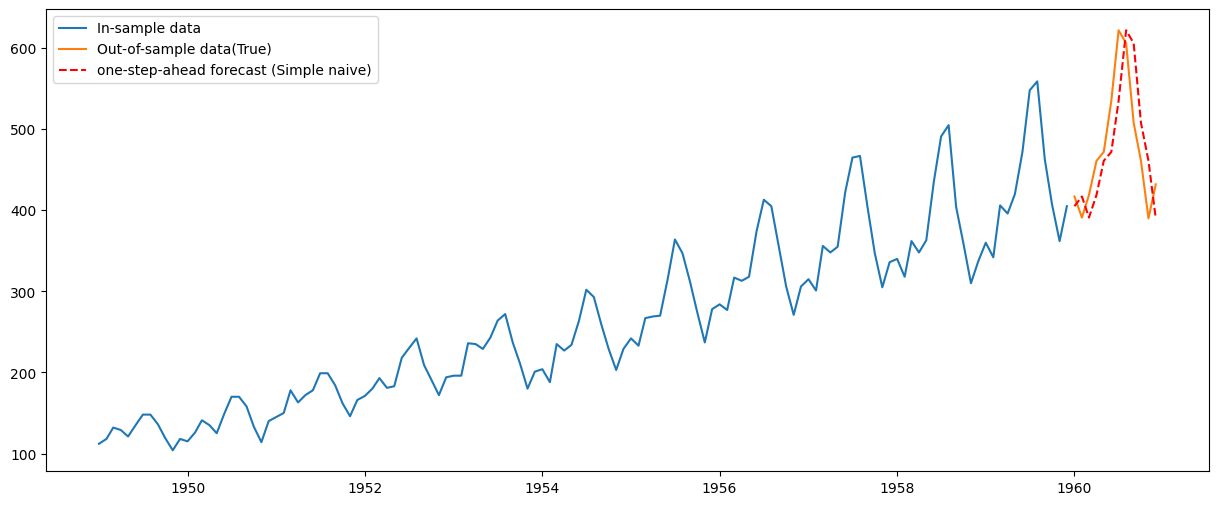

In [6]:
plt.figure(figsize=(15,6))
plt.plot(ts_in)
plt.plot(ts_out)
plt.plot(ts_one_step_naive1,'--r')
plt.legend(['In-sample data','Out-of-sample data(True)','one-step-ahead forecast (Simple naive)'])
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What does `'--r'` mean? 前面點點代表線的樣式後面的r代表顏色

- How to increase font size for legend and label in the figure above?

In some application, we also want to produce multi-step-ahead forecast values. e.g. $h>1$. For example, let's try to implement the case when $h=2$, e.g. two-step-ahead forecast, using the same naive forecasting method.

$$
\tag{3}
\begin{eqnarray}
\widehat{Y}_{T_{in}+1|T_{in}-1} &=& Y_{T_{in}-1}\\
\widehat{Y}_{T_{in}+2|T_{in}} &=& Y_{T_{in}}\\
\widehat{Y}_{T_{in}+3|T_{in}+1} &=& Y_{T_{in}+1}\\
... \\
\widehat{Y}_{T_{in}+h|T_{in}+h-2} &=& Y_{T_{in}+h-2}
\end{eqnarray}
$$

Now let's implement the algorithm (3). We also use a for loop to iterate through all steps in (3).

In [7]:
# Define the forecast horizon (two-step ahead)
h = 2   

# Create a Series to store forecast values (pre-allocation)
ts_two_step_naive1 = pd.Series(np.zeros(T_out))
ts_two_step_naive1.index = ts_out.index

# Create a for loop to iterate through out-of-sample time steps
for i in np.arange(T_out):
    ts_two_step_naive1[i] = ts[T_in+i-h]

Then it is useful to visualize the difference of one-step-ahead and two-step-ahead forecast values. Please note how do we add the legend this time. 

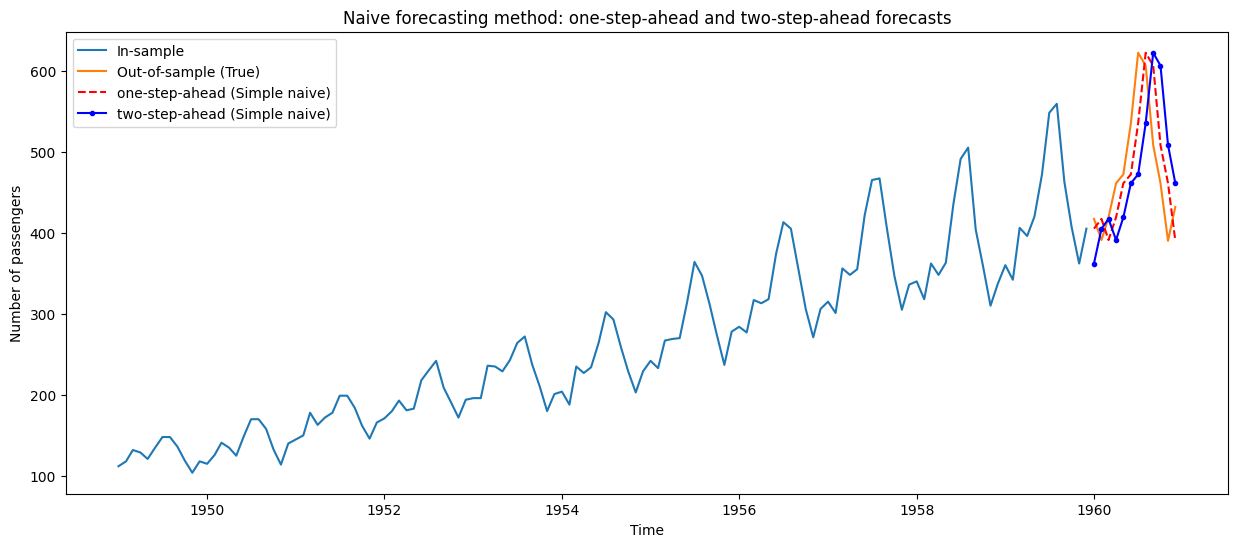

In [8]:
plt.figure(figsize=(15,6))
plt.plot(ts_in, label='In-sample')
plt.plot(ts_out, label='Out-of-sample (True)')
plt.plot(ts_one_step_naive1,'--r', label='one-step-ahead (Simple naive)')
plt.plot(ts_two_step_naive1,'.-b', label='two-step-ahead (Simple naive)')
plt.title('Naive forecasting method: one-step-ahead and two-step-ahead forecasts')
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.legend()#show legend
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why do we set value for the `label` argument of the `plt.plot()` function?

## 4.  Seasonal naive forecasing method: most recent seasonal's value

If the time series exhibits seasonality, then we can use most recent season’s value as the prediction. Denote $M$ the seasonal period, for example, the one-step-ahead forecast using seasonal naive forecasting method can be written as

$$
\tag{4}
\begin{eqnarray}
\widehat{Y}_{T_{in}+1|T_{in}} &=& Y_{T_{in}+1-M} \\
\widehat{Y}_{T_{in}+2|T_{in}+1} &=& Y_{T_{in}+2-M}\\
... \\
\widehat{Y}_{T_{in}+h|T_{in}+h-1} &=& Y_{T_{in}+h-M}
\end{eqnarray}
$$

Now let's implement the seasonal naive method in (3) for the AirPassenger data. To make it simple, we also use a for loop to iterate through each of out-of-sample time steps and assign corresponding values as shown in (3).

In [9]:
# Define forecast horizon (one-step ahead)
h = 1   

# Define the seasonal period
M = 12

# Create a Series to store forecast values (pre-allocation)
ts_one_step_naive2 = pd.Series(np.zeros(T_out))
ts_one_step_naive2.index = ts_out.index

# Create a loop 
for i in np.arange(T_out):
    ts_one_step_naive2[i] = ts[T_in+i-M]

# It is useful to put true and forecast out-out-sample data in the same DataFrame
ts_forecast_df['Pred_one_step_naive2'] = ts_one_step_naive2
ts_forecast_df

,Passengers,Pred_one_step_naive1,Pred_one_step_naive2
Month,,,
1960-01-01,417,405.0,360.0
1960-02-01,391,417.0,342.0
1960-03-01,419,391.0,406.0
1960-04-01,461,419.0,396.0
1960-05-01,472,461.0,420.0
1960-06-01,535,472.0,472.0
1960-07-01,622,535.0,548.0
1960-08-01,606,622.0,559.0
1960-09-01,508,606.0,463.0


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Can you replicate the above forecast values without using the for loop? (**Tasks**)



we can use shift


Now let's visualize the difference of (one-step-ahead) forecast values produced by two naive methods we have implemented so far

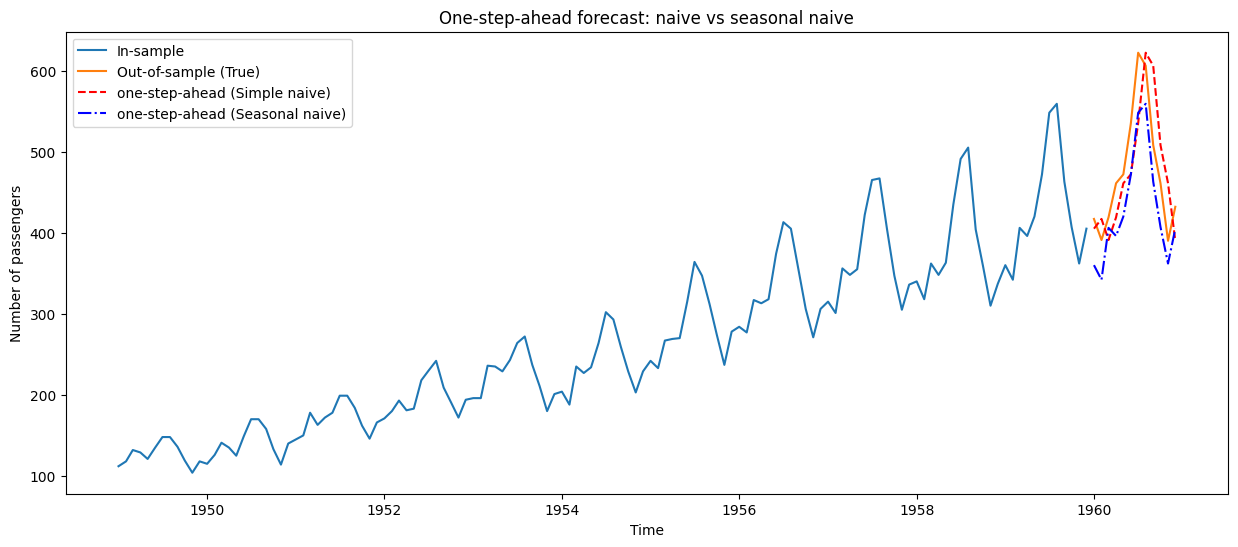

In [10]:
plt.figure(figsize=(15,6))
plt.plot(ts_in)
plt.plot(ts_out)
plt.plot(ts_one_step_naive1,'--r')
plt.plot(ts_one_step_naive2,'-.b')
plt.title('One-step-ahead forecast: naive vs seasonal naive')
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.legend(['In-sample','Out-of-sample (True)',
            'one-step-ahead (Simple naive)',
            'one-step-ahead (Seasonal naive)'])
plt.show()

## 5. Compare predictive performance of different forecasting methods

In order to access the predictive performance of a preditive model, we need to measure the accuracy of forecast values produced by the model. We do this by calculating the *difference* between forecast values and the corresponding observed (true) data points in the out-of-sample data. There are many ways to define the *difference*. In this tutorial, we use the Root Mean Squared Error (RMSE) measure which is defined as:

$$
RMSE = \sqrt{\frac{1}{T_{out}}\sum_{t=T_{in}+1}^T (Y_t-\widehat{Y}_t)^2}
$$

Since we will compute the RMSE measure for different candidate models, it is useful to define a simple function to compute the RMSE measure of two input arrays of the same length.

In [11]:
def RMSE(y_true,y_pred):
    mse = np.sqrt(np.mean((y_true-y_pred)**2))
    return(mse)

# predefine to cacu RMSE

Now we can use the `RMSE()` function to quickly compute the RMSE score of two models 

In [12]:
print('RMSE (Simple naive)  : {:.2f}'.format(RMSE(ts_out,ts_one_step_naive1)))
print('RMSE (Seasonal naive): {:.2f}'.format(RMSE(ts_out,ts_one_step_naive2)))
print('RMSE (Seasonal naive): {:.3f}'.format(RMSE(ts_out,ts_one_step_naive2)))
print('RMSE (Seasonal naive): {:.4f}'.format(RMSE(ts_out,ts_one_step_naive2)))


# seasonal naive is better than simple due to RMSE model

RMSE (Simple naive)  : 53.15
RMSE (Seasonal naive): 50.71
RMSE (Seasonal naive): 50.708
RMSE (Seasonal naive): 50.7083


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What does `{:.2f}` in the `print()` function mean?

The seasonal naive model makes forecast values with lower RMSE than those from the simple naive model. The only conclusion we can make here is that "for the AirPassenger dataset, Model 2 is better than Model 1 in term of predictive performance **measured in RMSE**". 

## 6. Forecast combination

An easy way to improve forecast accuracy is to use several different methods on the same time series, and to average the resulting forecasts. Since we have built two different models to make forecast values for the AirPassenger data, it is straightforward to implement the forecast combination by simply computing the weighted sum of forecast values produced by two models. Let's put equal weights on two models

In [13]:
# Define the weight (you can try different weights and observe the differences)
weight = 0.5

# Compute the weighted sum of forecast values produced by the two naive models
ts_one_step_combine = weight* ts_one_step_naive1 + (1-weight)*ts_one_step_naive2

# Compute RMSE of the new forecast values
print('RMSE (Forecast combination): {:.2f}'.format(RMSE(ts_out,ts_one_step_combine)))

RMSE (Forecast combination): 39.43


Interestingly, the combine model produce more accurate forecast values (measured in RMSE) than the individual model. 
Now let's visualize the new forecast values. We plot only the out-of-sample period this time to better visualize the difference between forecast values produced by 3 candidate models.

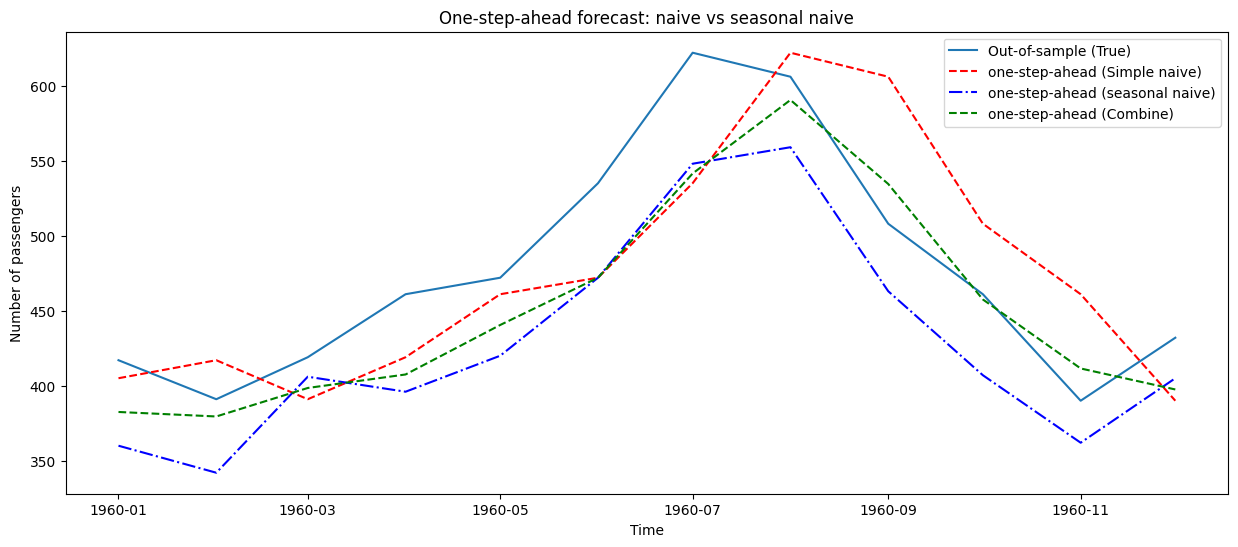

In [14]:
# Plot the forecast values together with theirs true data
plt.figure(figsize=(15,6))
plt.plot(ts_out)
plt.plot(ts_one_step_naive1,'--r')
plt.plot(ts_one_step_naive2,'-.b')
plt.plot(ts_one_step_combine,'--g')
plt.title('One-step-ahead forecast: naive vs seasonal naive')
plt.xlabel('Time')
plt.ylabel('Number of passengers')
plt.legend(['Out-of-sample (True)',
            'one-step-ahead (Simple naive)',
            'one-step-ahead (seasonal naive)',
            'one-step-ahead (Combine)'])
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Can you think of a useful stratergy to find a good value for `weight`?

# Tasks

For this week tasks, please re-use the AirPassenger dataset with the same train/test split ratio used in the tutorial 03.

1. Implement the simple naive forecasting method in Section 3 using the `shift()` method of Series class.
2. Implement the seasonal naive forecasting method in Section 4 without using the for loop (multiple solutions).
3. Repeat the comparison in Section 5 using different predictive measures, e.g. MAD and MAPE.



這個很重要一定要做
